<a href="https://colab.research.google.com/github/AKUG47/BPE-pytorch/blob/master/softmax_linreg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install d2l torchvision

In [2]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

d2l.use_svg_display()

In [3]:
# 通过ToTensor实例将图像数据从PIL类型变换成32位浮点数格式，
# 并除以255使得所有像素的数值均在0～1之间
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root="../data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
    root="../data", train=False, transform=trans, download=True)

100%|██████████| 26.4M/26.4M [00:01<00:00, 15.8MB/s]


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 270kB/s]


Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 5.05MB/s]


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 12.5MB/s]


Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



In [4]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [5]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

In [6]:
def get_fashion_mnist_labels(labels):
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [7]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

torch.Size([18, 1, 28, 28])


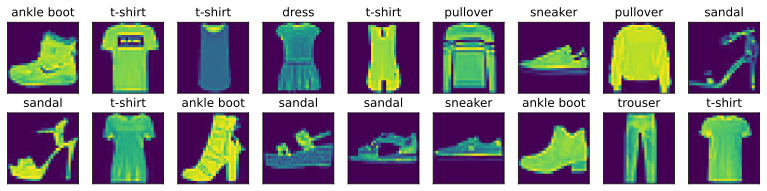

In [8]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
print(X.shape)
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y));

In [8]:
batch_size = 256

def get_dataloader_workers():
    """使用2个进程来读取数据"""
    return 2

train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,
                             num_workers=get_dataloader_workers())

In [10]:
timer = d2l.Timer()
for X, y in train_iter:
    continue
f'{timer.stop():.2f} sec'

'8.73 sec'

In [9]:
def load_data_fashion_mnist(batch_size, resize=None):
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64


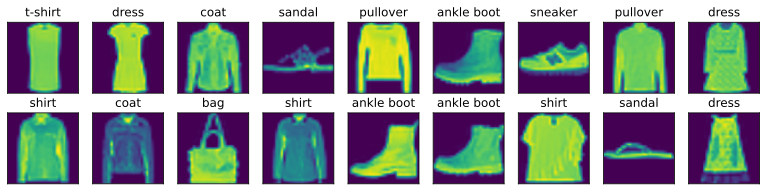

In [12]:
train_iter, test_iter = load_data_fashion_mnist(32, resize=64)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    show_images(X.reshape(32, 64, 64), 2, 9, titles=get_fashion_mnist_labels(y))
    break

In [10]:
from IPython import display

batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

In [11]:
def softmax(X):
    X_exps = torch.exp(X)
    partition = X_exps.sum(dim=1, keepdim=True)
    return X_exps / partition

In [12]:
num_inputs = 784
num_outputs = 10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

W.shape[0]

784

In [16]:
for X, y in train_iter:
    # print(X.reshape(-1, W.shape[0]).shape, X.shape, y.shape)
    print(y)
    # show_images(X.reshape(32, 64, 64), 2, 9, titles=get_fashion_mnist_labels(y))
    break

tensor([4, 3, 9, 4, 6, 8, 9, 8, 4, 6, 7, 3, 6, 4, 4, 2, 3, 0, 7, 1, 5, 6, 7, 1,
        0, 0, 3, 1, 7, 6, 0, 0, 4, 1, 6, 2, 2, 8, 5, 2, 5, 5, 4, 9, 5, 8, 5, 4,
        0, 5, 5, 6, 7, 6, 5, 7, 8, 6, 4, 0, 7, 6, 2, 9, 1, 9, 1, 9, 8, 5, 2, 2,
        0, 6, 9, 7, 8, 2, 2, 3, 7, 3, 8, 6, 9, 8, 2, 1, 7, 1, 0, 0, 1, 3, 1, 9,
        4, 9, 9, 9, 2, 2, 9, 7, 9, 1, 7, 6, 5, 9, 0, 1, 9, 0, 0, 8, 2, 5, 7, 7,
        9, 7, 3, 7, 8, 0, 3, 4, 1, 0, 9, 8, 2, 8, 2, 8, 0, 3, 3, 0, 3, 0, 0, 1,
        9, 4, 9, 1, 6, 9, 0, 3, 0, 9, 6, 9, 9, 6, 1, 8, 0, 5, 1, 6, 0, 4, 2, 2,
        2, 6, 2, 5, 1, 4, 4, 7, 8, 0, 9, 6, 8, 2, 9, 5, 2, 4, 1, 5, 5, 5, 2, 0,
        1, 7, 2, 2, 6, 1, 6, 3, 3, 7, 2, 1, 5, 5, 5, 1, 6, 9, 0, 0, 5, 8, 1, 3,
        0, 5, 8, 3, 9, 7, 2, 6, 7, 1, 1, 2, 8, 5, 9, 5, 7, 2, 9, 1, 9, 6, 6, 7,
        1, 4, 2, 7, 6, 1, 4, 9, 6, 2, 3, 0, 1, 0, 7, 8])


In [14]:
def net(X, b):
    return softmax(torch.matmul(X.reshape(-1, W.shape[0]), W) + b)

In [17]:
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[range(len(y_hat)), y])

In [18]:
def accuracy(y_hat, y):
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [ ]:
class Accumulator:
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [ a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def getitem(self, idx):
        return self.data[idx]

def evaluate_accuracy(net, data_iter):
    if isinstance(net, torch.nn.Module):
        net.eval()
    metric = Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), len(y))

    return metric.getitem(0) / metric.getitem(1)
